In [250]:
# importing necessary libraries
from string import punctuation
import pandas as pd
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import csv
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import classification_report
from wordcloud import WordCloud
from sklearn.metrics import f1_score

In [251]:
print(punctuation)

#class_names = ['negative','positive','neutral'] # Classification0
#class_names = ['negative','positive'] #Classification1,Movie_review
class_names = ['0','1','2','3','4'] #Classification2


!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [252]:
def fun1(review):
    review = review.lower() # lowercase, standardize
    return ''.join([c for c in review if c not in punctuation])

def fun2(x):
    if x=='negative':
        return 0
    elif x=='positive':
        return 1
    else:
        return 2

# Classification0,2 are imbalanced

df = pd.read_excel('../Assignments/Ass_1/ClassificationDataset2.xlsx',names = ['sentiment','review']) # classification2
#df = pd.read_excel('../Assignments/Ass_1/ClassificationDataset0.xlsx',names=['sentiment','review'],header = None) #Classification0
#df = pd.read_csv('../Assignments/Ass_1/all-data.csv',encoding="ISO-8859-1",names=['sentiment','review'],header = None) # all-data
#df = pd.read_csv('train.csv') # ../../Sentiment_classification(Movie_reviews)/train.csv, Classification1_new.csv

df = df.dropna()
df = df.sample(frac=1) # shuffles the data

# get rid of punctuation
df['review'] = df['review'].apply(fun1)
#df['sentiment'] = df['sentiment'].apply(fun2)  # Classification0,all_data
df['sentiment'] = df['sentiment'].apply(lambda x: x-1) # classification2

In [253]:
df.head()

,sentiment,review
2888,4,bought for my sons gopro3 he loves the gopro ...
2572,4,bought this for canon powershot n because it t...
81,4,great storage has not failed yet after about a...
3402,4,great microsdhc card use it on my phone for e...
1520,4,i bouthg this memory because in my contry not ...


<Axes: xlabel='sentiment', ylabel='count'>

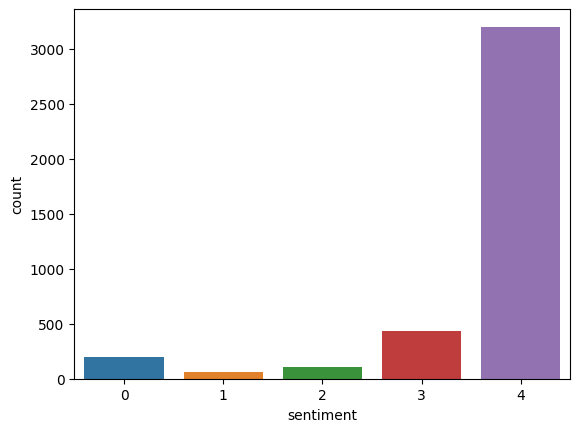

In [254]:
sns.countplot(data = df, x = 'sentiment')

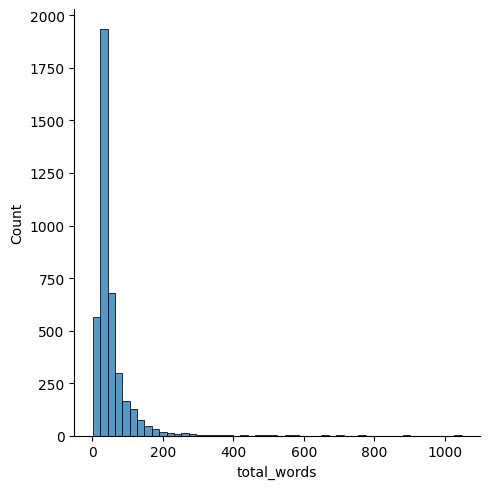

In [255]:
df['total_words'] = df['review'].apply(lambda x: len(x.split(' ')))
sns.displot(df,x = 'total_words',bins = 50)

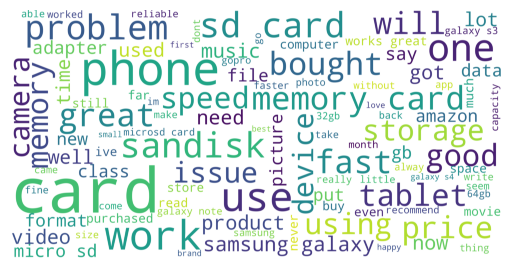

In [256]:
# Most frequent words
word_cloud_text = ''.join(df['review'])

wordcloud = WordCloud(max_font_size=100, # Maximum font size for the largest word
                      max_words=100, # The maximum number of words
                      background_color="white", # Background color for the word cloud image
                      scale = 10, # Scaling between computation and drawing
                      width=800, # Width of the canvas
                      height=400 # Height of the canvas
                     ).generate(word_cloud_text)

plt.figure()
plt.imshow(wordcloud, 
           interpolation="bilinear") # to make the displayed image appear more smoothly
plt.axis("off")
plt.show()

In [257]:
print("Min = ",df['total_words'].min())
print("Max = ",df['total_words'].max())
print("Mean = ",df['total_words'].mean())

Min =  1
Max =  1048
Mean =  50.44872436218109


In [258]:
dict_path = '/data4/home/manikantab/Diffusion_models/NLP/Hierarchical-attention-networks-pytorch/data/glove.6B.50d.txt'
#dict_path = '../Assignments/glove.42B.300d.txt'

In [259]:
reviews_split = list(df['review'].values)
words = [word for review in reviews_split for word in review.split(' ')]

In [260]:
words[:30]

['bought',
 'for',
 'my',
 'sons',
 'gopro3',
 '',
 'he',
 'loves',
 'the',
 'gopro',
 'and',
 'this',
 'accessory',
 'is',
 'great',
 '',
 'allows',
 'him',
 'to',
 'film',
 'for',
 'long',
 'stretches',
 'and',
 'then',
 'he',
 'comes',
 'in',
 'downloads',
 'and']

In [261]:
## Build a dictionary that maps words to integers
counts = Counter(words)
vocab = sorted(counts, key=counts.get, reverse=True)
vocab_to_int = {word: ii for ii, word in enumerate(vocab,1)}

wordss = pd.read_csv(filepath_or_buffer=dict_path, header=None, sep=" ", quoting=csv.QUOTE_NONE,
                                usecols=[0]).values
dict = {'<unk':0,'<pad>':1}
int_to_word = {0:'<unk>',1:'<pad>'}
        # use index 0 for <unk> token
        # use index 1 for <pad> token
for i,word in enumerate(wordss):
  dict[word[0]] = i+2
  int_to_word[i+2] = word[0]

## use the dict to tokenize each review in reviews_split
## store the tokenized reviews in reviews_ints
reviews_ints = []
for review in reviews_split:
  #reviews_ints.append([vocab_to_int[word] for word in review.split()])
  l = []
  for word in review.split():
    if word in dict:
      l.append(dict[word])
    else:
      l.append(0)
  reviews_ints.append(l)

In [262]:
# stats about vocabulary
print('Unique words: ', len((vocab_to_int)))  # should ~ 74000+
print()

# print tokens in first review
print('Tokenized review: \n', reviews_ints[:1])
word = ''
for i in reviews_ints[0]:
    word = word+' '+int_to_word[i]
print(word)

Unique words:  9758

Tokenized review: 
 [[1777, 12, 194, 2914, 0, 20, 6743, 2, 331725, 7, 39, 20339, 16, 355, 2417, 105, 6, 321, 12, 175, 10178, 7, 129, 20, 936, 8, 17898, 7, 20409]]
 bought for my sons <unk> he loves the gopro and this accessory is great allows him to film for long stretches and then he comes in downloads and edits


In [263]:
encoded_labels = df['sentiment'].values

In [264]:
# outlier review stats
review_lens = Counter([len(x) for x in reviews_ints])
print("Zero-length reviews: {}".format(review_lens[0]))
print("Maximum review length: {}".format(max(review_lens)))

Zero-length reviews: 0
Maximum review length: 1030


In [266]:
# Removes zero length reviews

print('Number of reviews before removing outliers: ', len(reviews_ints))

## remove any reviews/labels with zero length from the reviews_ints list.

## get any indices of any reviews with length 0
non_zero_idx = [ii for ii, review in enumerate(reviews_ints) if len(review) != 0]

# remove 0-length review with their labels
reviews_ints = [reviews_ints[ii] for ii in non_zero_idx]
encoded_labels = np.array([encoded_labels[ii] for ii in non_zero_idx])

print('Number of reviews after removing outliers: ', len(reviews_ints))

Number of reviews before removing outliers:  3998
Number of reviews after removing outliers:  3998


In [267]:
def pad_features(reviews_ints, seq_length):
    ''' Return features of review_ints, where each review is padded with 0's
        or truncated to the input seq_length.
    '''
    ## getting the correct rows x cols shape
    features = np.zeros((len(reviews_ints), seq_length), dtype=int)

    ## for each review, I grab that review
    for i, row in enumerate(reviews_ints):
      #features[i, -len(row):] = np.array(row)[:seq_length]
      features[i, :min(len(row),seq_length)] = np.array(row)[:seq_length]

    return features

In [268]:
# Test your implementation!

seq_length = 100 # or choose this based on the statistics of the review length

features = pad_features(reviews_ints, seq_length=seq_length)

## test statements - do not change - ##
assert len(features)==len(reviews_ints), "Your features should have as many rows as reviews."
assert len(features[0])==seq_length, "Each feature row should contain seq_length values."

# print first 10 values of the first 30 batches
print(features[:30,-10:])

[[    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [14665  3522  1924  5117    15   160   656    36 14665  7394]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0

In [269]:
split_frac = 0.9

## split data into training, validation, and test data (features and labels, x and y)
split_idx = int(len(features)*0.9)

train_x, val_x = features[:split_idx], features[split_idx:]
train_y, val_y = encoded_labels[:split_idx], encoded_labels[split_idx:]

# train_x, remaining_x = features[:split_idx], features[split_idx:]
# train_y, remaining_y = encoded_labels[:split_idx], encoded_labels[split_idx:]

# test_idx = int(len(remaining_x)*0.5)
# val_x, test_x = remaining_x[:test_idx], remaining_x[test_idx:]
# val_y, test_y = remaining_y[:test_idx], remaining_y[test_idx:]

## print out the shapes of your resultant feature data
print("\t\t\tFeatures Shapes:")
print("Train set: \t\t{}".format(train_x.shape),
      "\nValidation set: \t{}".format(val_x.shape))
      #"\nTest set: \t\t{}".format(test_x.shape))



			Features Shapes:
Train set: 		(3598, 100) 
Validation set: 	(400, 100)


In [270]:
print("Train  -- ",Counter(train_y))
print("Val  -- ",Counter(val_y))

Train  --  Counter({4: 2891, 3: 385, 0: 166, 2: 96, 1: 60})
Val  --  Counter({4: 312, 3: 48, 0: 28, 2: 10, 1: 2})


In [271]:


# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
valid_data = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))
#test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

# dataloaders
batch_size = 64

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)
#test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [272]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print()
print('Sample label size: ', sample_y.size()) # batch_size
print('Sample label: \n', sample_y)

Sample input size:  torch.Size([64, 100])
Sample input: 
 tensor([[  43,  743,    9,  ...,    0,    0,    0],
        [ 182,   39,    8,  ...,    0,    0,    0],
        [1777,   39,    6,  ...,    0,    0,    0],
        ...,
        [  43,   35,   86,  ...,    0,    0,    0],
        [   9,  145,  118,  ...,    0,    0,    0],
        [1777,   39,    6,  ...,    0,    0,    0]])

Sample label size:  torch.Size([64])
Sample label: 
 tensor([4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 3, 4, 4, 4, 4,
        4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 2, 4, 4, 1, 4, 3, 4, 4, 4, 3, 3, 1, 4, 3, 4])


In [273]:
# First checking if GPU is available
train_on_gpu=torch.cuda.is_available()

if(train_on_gpu):
    print('Training on GPU.')
else:
    print('No GPU available, training on CPU.')

Training on GPU.


In [274]:
device = 'cuda:6'

In [276]:

class SentimentRNN(nn.Module):
    """
    The RNN model that will be used to perform Sentiment analysis.
    """

    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        """
        Initialize the model by setting up the layers.
        """
        super(SentimentRNN, self).__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim


        dict = pd.read_csv(filepath_or_buffer=dict_path, header=None, sep=" ", quoting=csv.QUOTE_NONE).values[:, 1:]
        dict_len, embed_size = dict.shape
        dict_len += 2
        # index 0 for <unk>
        # index 1 for <pad>
        unk_pad = np.zeros((2, embed_size))
        dict = torch.from_numpy(np.concatenate([unk_pad, dict], axis=0).astype(np.float32))
        # embedding and LSTM layers
        # self.embedding = nn.Embedding(vocab_size, embedding_dim)

        #embed_size = embedding_dim
        self.embedding = nn.Embedding(dict_len, embed_size).from_pretrained(dict)
        
        self.lstm = nn.LSTM(embed_size, hidden_dim, n_layers,
                            dropout=drop_prob, batch_first=True)

        # dropout layer
        self.dropout = nn.Dropout(0.3)

        # linear and sigmoid layer
        self.fc = nn.Linear(hidden_dim, output_size)
        #self.sig = nn.Sigmoid()

    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)

        #print(x.shape)

        # embeddings and lstm_out
        embeds = self.embedding(x)

        #print(embeds.shape)
        
        lstm_out, hidden = self.lstm(embeds, hidden)
        
        # stack up lstm outputs
        #lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        lstm_out = lstm_out[:,-1,:]

        # dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)

        # sigmoid function
        #sig_out = self.sig(out)

        # reshape to be batch_size first
        #sig_out = sig_out.view(batch_size, -1)
        #sig_out = sig_out[:, -1] # get last batch of labels

        # return last sigmoid output and hidden state
        return out, hidden


    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data

        if(train_on_gpu):
          hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                   weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        else:
          hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                   weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())

        return hidden


In [277]:
# Instantiate the model w/ hyperparams
vocab_size = len(vocab_to_int) + 1 # +1 for zero padding + our word tokens
output_size = len(class_names) # classes in dataset
embedding_dim = 400
hidden_dim = 256
n_layers = 2

net = SentimentRNN(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)

print(net)

SentimentRNN(
  (embedding): Embedding(400002, 50)
  (lstm): LSTM(50, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=5, bias=True)
)


In [278]:
# loss and optimization functions
lr=0.001

#criterion = nn.BCELoss()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr,weight_decay=1e-2)


In [279]:
# training params

epochs = 10 # 3-4 is approx where I noticed the validation loss stop decreasing

counter = 0
print_every = 100
clip=5 # gradient clipping

# move model to GPU, if available
if(train_on_gpu):
    net =  net.to(device)

best_val_acc = 0.8

net.train()
# train for some number of epochs
for e in range(epochs):
    # initialize hidden state
    h = net.init_hidden(batch_size)

    # batch loop
    for inputs, labels in train_loader:
        counter += 1

        if(train_on_gpu):
            inputs, labels = inputs.to(device), labels.to(device)

        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        # h = tuple([each.data for each in h])
        h = net.init_hidden(inputs.size(0))

        # zero accumulated gradients
        net.zero_grad()

        # get the output from the model
        output, h = net(inputs, h)

        # calculate the loss and perform backprop
        #loss = criterion(output.squeeze(), labels.float())
        loss = criterion(output, labels)
        loss.backward()
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()

        # loss stats
        if counter % print_every == 0:
            # Get validation loss
            val_h = net.init_hidden(batch_size)
            val_losses = []
            num_correct = 0
            net.eval()
            for inputs, labels in valid_loader:

                # Creating new variables for the hidden state, otherwise
                # we'd backprop through the entire training history
                #val_h = tuple([each.data for each in val_h]) # if we do this we need to worry about whether val_h aligns with batch_size of last batch
                val_h = net.init_hidden(inputs.size(0))

                if(train_on_gpu):
                    inputs, labels = inputs.to(device), labels.to(device)

                output, val_h = net(inputs, val_h)
                #val_loss = criterion(output.squeeze(), labels.float())
                val_loss = criterion(output, labels)

                val_losses.append(val_loss.item())

                pred = output.softmax(dim = 1).argmax(dim = 1)

                # compare predictions to true label
                correct_tensor = pred.eq(labels.float().view_as(pred))
                correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
                num_correct += np.sum(correct)

            val_acc = num_correct/len(valid_loader.dataset)
            net.train()
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)),
                  "Val Accuracy: {:.6f}".format(val_acc))
            


Epoch: 2/10... Step: 100... Loss: 0.898874... Val Loss: 0.755632 Val Accuracy: 0.780000
Epoch: 4/10... Step: 200... Loss: 0.547177... Val Loss: 0.754512 Val Accuracy: 0.780000
Epoch: 6/10... Step: 300... Loss: 0.937888... Val Loss: 0.777740 Val Accuracy: 0.780000
Epoch: 8/10... Step: 400... Loss: 0.755844... Val Loss: 0.785470 Val Accuracy: 0.780000
Epoch: 9/10... Step: 500... Loss: 0.602555... Val Loss: 0.812855 Val Accuracy: 0.780000


In [280]:
# Get test data loss and accuracy

test_losses = [] # track loss
total_pred = []
total_correct = []
num_correct = 0

# init hidden state
h = net.init_hidden(batch_size)

net.eval()
# iterate over test data
for inputs, labels in valid_loader:

    # Creating new variables for the hidden state, otherwise
    # we'd backprop through the entire training history
    # h = tuple([each.data for each in h])
    h = net.init_hidden(inputs.size(0))

    if(train_on_gpu):
        inputs, labels = inputs.to(device), labels.to(device)

    # get predicted outputs
    output, h = net(inputs, h)

    # calculate loss
    # test_loss = criterion(output.squeeze(), labels.float())
    test_loss = criterion(output, labels)
    test_losses.append(test_loss.item())

    # convert output probabilities to predicted class (0 or 1)
    #pred = torch.round(output.squeeze())  # rounds to the nearest integer
    pred = output.softmax(dim = 1).argmax(dim = 1)

    total_pred.extend(list(pred.cpu().numpy()))
    total_correct.extend(list(labels.cpu().numpy()))


    # compare predictions to true label
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)


# -- stats! -- ##
# avg test loss
print("Test loss: {:.3f}".format(np.mean(test_losses)))

# accuracy over all test data
test_acc = num_correct/len(valid_loader.dataset)
print("Test accuracy: {:.3f}".format(test_acc))


print(classification_report(total_correct, total_pred,target_names=class_names))

macroF1 = f1_score(total_correct, total_pred, average='macro')
microF1 = f1_score(total_correct, total_pred, average='micro')

print("\n------------- Micro F1 Score == {} ------------".format(microF1))
print("------------- Macro F1 Score == {} ------------\n".format(macroF1))


Test loss: 0.749
Test accuracy: 0.780
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        48
           4       0.78      1.00      0.88       312

    accuracy                           0.78       400
   macro avg       0.16      0.20      0.18       400
weighted avg       0.61      0.78      0.68       400


------------- Micro F1 Score == 0.78 ------------
------------- Macro F1 Score == 0.1752808988764045 ------------



/data4/home/manikantab/Diffusion_models/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data4/home/manikantab/Diffusion_models/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data4/home/manikantab/Diffusion_models/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

In [148]:
# negative test review
test_review_neg = 'The worst movie I have seen; acting was terrible and I want my money back. This movie had bad acting and the dialogue was slow.'


In [149]:
def tokenize_review(test_review):
    test_review = test_review.lower() # lowercase
    # get rid of punctuatuon
    test_text = ''.join([c for c in test_review if c not in punctuation])

    # splitting by spaces
    test_words = test_text.split()

    # tokens
    test_ints = []
    #test_ints.append([vocab_to_int[word] for word in test_words])
    l = []
    for word in test_words:
        if word in dict:
            l.append(dict[word])
        else:
            l.append(0)
    test_ints.append(l)

    return test_ints

# test code and generate tokenized review
test_ints = tokenize_review(test_review_neg)
print(test_ints)

[[2, 1609, 1007, 43, 35, 543, 2052, 17, 5512, 7, 43, 305, 194, 310, 139, 39, 1007, 42, 980, 2052, 7, 2, 2471, 17, 2051]]


In [150]:
# test sequence padding
#seq_length = 20
features = pad_features(test_ints, seq_length)

print(features)

[[   2 1609 1007   43   35  543 2052   17 5512    7   43  305  194  310
   139   39 1007   42  980 2052]]


In [151]:
# test conversion to tensor and pass it to model
feature_tensor = torch.from_numpy(features)
print(feature_tensor.size())

torch.Size([1, 20])


In [152]:
def predict(net, test_review, sequence_length=200):
    ''' Prints out whether a give review is predicted to be
        positive or negative in sentiment, using a trained model.

        params:
        net - A trained net
        test_review - a review made of normal text and punctuation
        sequence_length - the padded length of a review
        '''

    net.eval()

    # tokenize review
    test_ints = tokenize_review(test_review)

    # pad tokenize sequence
    seq_length = sequence_length
    features = pad_features(test_ints, seq_length)

    # convert to tensor to pass to model
    feature_tensor = torch.from_numpy(features)

    batch_size = feature_tensor.size(0)

    # initialize hidden state
    h = net.init_hidden(batch_size)

    if(train_on_gpu):
      feature_tensor = feature_tensor.to(device)

    # get the output from the model
    output, h = net(feature_tensor, h)

    # convert output probabilities to predicted class (0 or 1)
    #pred = torch.round(output.squeeze())
    pred = output.softmax(dim = 1).argmax(dim = 1)
    # printing output value, before rounding
    # print('Prediction value, pre-rounding: {:.6f}'.format(output.item()))
    print('Prediction value, pre-rounding: {}'.format(output.softmax(dim = 1)))

    # print custom response based on whether test_review is pos/neg
    if(pred.item()==1):
      print('Positive review detected!')
    else:
      print('Negative review detected!')



In [153]:
# positive test review
test_review_pos = 'This movie had the best acting and the dialogue was so good. I loved it.'


In [154]:
# call function
# try negative and positive reviews!
#seq_length=200
predict(net, test_review_neg, seq_length)
predict(net, test_review_pos, seq_length)

Prediction value, pre-rounding: tensor([[0.9330, 0.0670]], device='cuda:6', grad_fn=<SoftmaxBackward>)
Negative review detected!
Prediction value, pre-rounding: tensor([[0.0386, 0.9614]], device='cuda:6', grad_fn=<SoftmaxBackward>)
Positive review detected!


### Try out test_reviews of your own!

Now that you have a trained model and a predict function, you can pass in _any_ kind of text and this model will predict whether the text has a positive or negative sentiment. Push this model to its limits and try to find what words it associates with positive or negative.

Later, you'll learn how to deploy a model like this to a production environment so that it can respond to any kind of user data put into a web app!